In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from captum.attr import IntegratedGradients, LayerIntegratedGradients
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
class SequenceDataset(Dataset):
    def __init__(self, df, exog_col='exog', endog_col='endog'):
        """
        df: a pandas DataFrame with two columns:
            - exog_col: list of integers (sequence)
            - endog_col: binary label (0 or 1)
        """
        self.sequences = df[exog_col].tolist()
        self.labels = df[endog_col].tolist()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [4]:
def collate_fn(batch):
    """
    Pads sequences in a batch to the same length.
    """
    # Separate sequences and labels
    sequences, labels = zip(*batch)

    # Find max length within this batch
    max_length = max(len(seq) for seq in sequences)

    # Pad sequences with 0 (or a special PAD token id if you have one)
    padded_sequences = []
    for seq in sequences:
        padded = seq + [34]*(max_length - len(seq))
        padded_sequences.append(padded)

    # Convert to tensors
    padded_sequences = torch.tensor(padded_sequences, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.float)

    return padded_sequences, labels

In [5]:
def test_collate_fn(batch):
    """
    Pads sequences in a batch and preserves original indices.
    """
    # Separate sequences, labels, and indices
    sequences, labels, indices = zip(*batch)

    # Find max length within this batch
    max_length = max(len(seq) for seq in sequences)

    # Pad sequences with 34 (which appears to be your padding token)
    padded_sequences = []
    for seq in sequences:
        padded = seq + [34]*(max_length - len(seq))
        padded_sequences.append(padded)

    # Convert to tensors
    padded_sequences = torch.tensor(padded_sequences, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.float)
    indices = torch.tensor(indices)

    return padded_sequences, labels, indices

In [6]:
class TransformerBinaryClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim=64,
        num_heads=2,
        num_layers=2,
        ff_dim=128,
        dropout=0.1
    ):
        """
        vocab_size: size of the vocabulary (max integer token + 1).
        embed_dim: embedding dimension.
        num_heads: number of attention heads in the MultiheadAttention.
        num_layers: number of transformer encoder layers to stack.
        ff_dim: hidden dim in the feed-forward network of each encoder layer.
        dropout: dropout probability.
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Positional encoding (optional). If sequences can be very long,
        # consider a standard sinusoidal positional encoding approach.
        # Here we just show a simple learned positional embedding for demonstration:
        self.pos_embedding = nn.Embedding(5000, embed_dim)  # 5000 is arbitrary

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True  # ensures shape is (batch, seq, embed_dim)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.classifier = nn.Linear(embed_dim, 1)  # single output for binary

    def forward(self, x):
        """
        x: [batch_size, seq_len] of token IDs
        """
        batch_size, seq_len = x.shape

        # Token embeddings
        token_embeddings = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        # Positional embeddings (very simple version)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)  # [1, seq_len]
        pos_embeddings = self.pos_embedding(positions)  # [1, seq_len, embed_dim]

        # Combine token and positional embeddings
        embeddings = token_embeddings + pos_embeddings

        # Transformer Encoder
        encoder_output = self.transformer_encoder(embeddings)  
        # [batch_size, seq_len, embed_dim]

        # For classification, we often just take the output at the last token
        # or the pooled [CLS] representation if we have one. Another approach:
        # do a mean or max pooling across seq_len.
        # We'll do mean pooling across the sequence dimension:
        pooled_output = encoder_output.mean(dim=1)  # [batch_size, embed_dim]

        # Final linear layer -> raw logits
        logits = self.classifier(pooled_output).squeeze(-1)  # [batch_size]

        return logits

In [7]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=5, 
    lr=1e-3, 
    device='cuda'
):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # GradScaler for scaling loss in mixed precision
    scaler = GradScaler()
    
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_acc = 0.0
        total_count = 0

        for sequences, labels in train_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass under autocast
            # You can optionally set the precision as fp16 or bfloat16 below
            # with autocast(device_type='cuda', dtype=torch.bfloat16):
            with autocast():
                logits = model(sequences)
                loss = criterion(logits, labels)

            # Backward pass with GradScaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Compute training accuracy
            preds = torch.sigmoid(logits)
            preds_class = (preds >= 0.5).float()
            acc = (preds_class == labels).float().sum()

            # Accumulate metrics
            batch_size = sequences.size(0)
            total_loss += loss.item() * batch_size
            total_acc += acc.item()
            total_count += batch_size

        avg_train_loss = total_loss / total_count
        avg_train_acc = total_acc / total_count
        
        # Evaluate on validation set (optionally also under autocast)
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

In [8]:
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_count = 0

    with torch.no_grad():
        # with autocast(device_type='cuda'):
        for sequences, labels in data_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            logits = model(sequences)
            loss = criterion(logits, labels)

            preds = torch.sigmoid(logits)
            preds_class = (preds >= 0.5).float()
            acc = (preds_class == labels).float().sum()

            batch_size = sequences.size(0)
            total_loss += loss.item() * batch_size
            total_acc += acc.item()
            total_count += batch_size

    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc


In [9]:
def evaluate_on_test_set(model, test_loader, device='cuda'):
    """
    Generates predictions on the test set, then plots the ROC curve and prints the AUC.
    """
    model.eval()
    
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for sequences, labels, _ in test_loader:  # Now correctly unpacks 3 values
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(sequences)
            # Convert logits -> probabilities in [0, 1]
            probs = torch.sigmoid(logits)

            # Collect results for ROC
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Set ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Test AUC: {roc_auc:.3f}")

    return roc_auc, all_labels, all_probs

# Load and split

In [9]:
load = pd.read_csv('full_hands_df.csv')
load['seq'] = load['seq'].apply(ast.literal_eval)

In [10]:
load = load[['seq','is_chiitoi']]
load = load.rename(columns={'seq':'exog','is_chiitoi':'endog'})

In [11]:
load.shape

(210550, 2)

In [12]:
df = load.copy()

In [56]:
train, test = train_test_split(df, test_size=0.2)

train, val = train_test_split(train, test_size=0.1)

In [127]:
# train.to_csv('run_3_11_2025/train.csv')
# test.to_csv('run_3_11_2025/test.csv')
# val.to_csv('run_3_11_2025/val.csv')

In [10]:
train = pd.read_csv('run_3_11_2025/train.csv')
train = train.rename(columns={'Unnamed: 0': 'orig_index'})
test = pd.read_csv('run_3_11_2025/test.csv')
test = test.rename(columns={'Unnamed: 0': 'orig_index'})
val = pd.read_csv('run_3_11_2025/val.csv')
val = val.rename(columns={'Unnamed: 0': 'orig_index'})
test['exog'] = test['exog'].apply(ast.literal_eval)
val['exog'] = val['exog'].apply(ast.literal_eval)
train['exog'] = train['exog'].apply(ast.literal_eval)

In [11]:
class TestSequenceDataset(Dataset):
    def __init__(self, df, exog_col='exog', endog_col='endog', orig_idx_col='orig_index'):
        """
        df: a pandas DataFrame with two columns:
            - exog_col: list of integers (sequence)
            - endog_col: binary label (0 or 1)
        """
        self.df = df
        self.sequences = df[exog_col].tolist()
        self.labels = df[endog_col].tolist()
        self.indices = df[orig_idx_col].tolist()  # Store the original indices

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Return sequence, label, and original index
        return self.sequences[idx], self.labels[idx], self.indices[idx]

In [12]:
val.shape

(16844, 3)

# Train

In [13]:
train_dataset = SequenceDataset(train)
val_dataset = SequenceDataset(val)
test_dataset = TestSequenceDataset(test)

In [14]:
train_loader = DataLoader(train_dataset, 
                          batch_size=8192, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          num_workers=8,
                          pin_memory=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=8192, 
                        shuffle=False, 
                        collate_fn=collate_fn,
                        num_workers=8,
                        pin_memory=True)

test_loader = DataLoader(
    test_dataset, 
    batch_size=512, 
    shuffle=False, 
    collate_fn=test_collate_fn
)

In [15]:
vocab_size = 35

In [16]:
device = torch.device("cuda")

In [129]:
model = TransformerBinaryClassifier(
    vocab_size=vocab_size,
    embed_dim=32,
    num_heads=2,
    num_layers=10,
    ff_dim=64,
    dropout=0.1
)

In [68]:
train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3, device=device)

/tmp/ipykernel_1580/49820654.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1580/49820654.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/30] Train Loss: 0.0853, Train Acc: 0.9831, Val Loss: 0.0932, Val Acc: 0.9802
Epoch [2/30] Train Loss: 0.0820, Train Acc: 0.9831, Val Loss: 0.0913, Val Acc: 0.9802
Epoch [3/30] Train Loss: 0.0809, Train Acc: 0.9831, Val Loss: 0.0945, Val Acc: 0.9802
Epoch [4/30] Train Loss: 0.0806, Train Acc: 0.9831, Val Loss: 0.0898, Val Acc: 0.9802
Epoch [5/30] Train Loss: 0.0796, Train Acc: 0.9831, Val Loss: 0.0892, Val Acc: 0.9802
Epoch [6/30] Train Loss: 0.0787, Train Acc: 0.9831, Val Loss: 0.0884, Val Acc: 0.9802
Epoch [7/30] Train Loss: 0.0783, Train Acc: 0.9831, Val Loss: 0.0882, Val Acc: 0.9802
Epoch [8/30] Train Loss: 0.0779, Train Acc: 0.9831, Val Loss: 0.0877, Val Acc: 0.9801
Epoch [9/30] Train Loss: 0.0776, Train Acc: 0.9830, Val Loss: 0.0878, Val Acc: 0.9802
Epoch [10/30] Train Loss: 0.0775, Train Acc: 0.9831, Val Loss: 0.0871, Val Acc: 0.9802
Epoch [11/30] Train Loss: 0.0771, Train Acc: 0.9831, Val Loss: 0.0882, Val Acc: 0.9802
Epoch [12/30] Train Loss: 0.0771, Train Acc: 0.9831,

In [17]:
model = torch.load('models/0.7521308862769939.pth', weights_only=False)

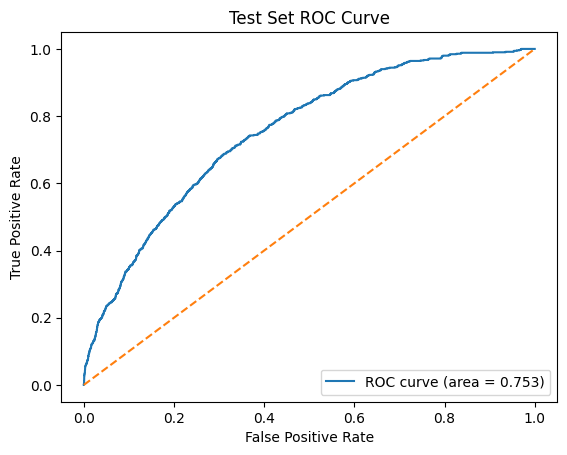

Test AUC: 0.753
Test AUC: 0.7530425057249999


In [18]:
model.to(device)
test_auc, labels, probs = evaluate_on_test_set(model, test_loader, device=device)
print("Test AUC:", test_auc)

In [72]:
test_auc

np.float64(0.7521308862769939)

In [71]:
# torch.save(model, f'models/{test_auc}.pth')

# Tune?

# Explainability

In [42]:
df = pd.DataFrame({'labels': labels, 'probabilities': probs})

In [43]:
test

,exog,endog
Unnamed: 0,,
141675,"[1, 0, 7, 0, 13, 27, 26, 9, 8, 7, 33, 28]",0
36486,"[1, 0, 5, 0, 3, 29, 33, 8, 3, 21]",0
156052,"[1, 0, 7, 0, 3, 18, 28, 2, 31, 7, 30, 19]",0
158657,"[0, 1, 3, 0, 9, 26, 8, 7]",0
209151,"[1, 0, 5, 0, 30, 18, 9, 9, 31, 27]",0
...,...,...
181796,"[1, 1, 10, 0, 18, 9, 26, 24, 26, 1, 33, 4, 6, ...",0
123005,"[0, 0, 12, 0, 18, 28, 28, 29, 33, 30, 32, 1, 2...",0
27216,"[2, 0, 16, 0, 9, 30, 32, 32, 31, 2, 29, 27, 19...",0


In [44]:
test_res = df.merge(test.reset_index(), left_index=True, right_index=True)

In [46]:
test_res_sort = test_res.sort_values('probabilities', ascending=False)[['exog','endog','probabilities']]
test_res_sort

,exog,endog,probabilities
2849,"[1, 0, 17, 0, 27, 31, 20, 28, 18, 1, 16, 30, 2...",0,0.653616
13440,"[1, 0, 16, 0, 30, 29, 26, 17, 27, 31, 32, 0, 1...",0,0.626463
41304,"[0, 0, 18, 0, 31, 27, 33, 30, 24, 12, 33, 14, ...",0,0.601865
33658,"[1, 0, 17, 0, 29, 9, 0, 8, 18, 33, 25, 33, 3, ...",0,0.601678
26760,"[0, 0, 17, 0, 11, 28, 32, 17, 18, 31, 29, 9, 6...",1,0.594993
...,...,...,...
33474,"[0, 0, 10, 0, 9, 30, 30, 33, 9, 28, 32, 30, 27...",0,0.001103
37452,"[1, 0, 5, 0, 1, 27, 17, 29, 30, 7]",0,0.001102
6065,"[1, 0, 9, 0, 33, 27, 0, 29, 33, 27, 28, 32, 30...",0,0.001102
1182,"[1, 0, 10, 0, 22, 27, 17, 17, 31, 31, 28, 29, ...",0,0.001101


## Integrated Gradients

In [71]:
def gen_integrated_gradients_frame(model, test_loader, device='cuda', vocab_size=35):
    """
    Analyzes model predictions using Integrated Gradients, preserving original indices.
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data with indices
        device: Device to run the model on ('cuda' or 'cpu')
        vocab_size: Size of the vocabulary used in the model
        
    Returns:
        DataFrame with token attributions and original indices
    """
    model.eval()
    model.to(device)
    
    # Initialize the LayerIntegratedGradients
    lig = LayerIntegratedGradients(model.forward, model.embedding)

    # Create lists to collect all data
    all_orig_indices = []
    all_tokens = []
    all_scores = []
    all_labels = []
    all_probs = []
    
    # Get batches of data
    for inputs, labels, orig_indices in tqdm(test_loader):
        # Ensure all input tokens are within the vocab_size range
        inputs = torch.clamp(inputs, 0, vocab_size-1)
        
        # Move data to the appropriate device
        inputs = inputs.to(device, dtype=torch.long)
        labels = labels.to(device)
        
        # Get predictions to store alongside attributions
        with torch.no_grad():
            logits = model(inputs)
            probs = torch.sigmoid(logits).cpu().numpy()
        
        # Create a baseline tensor filled with zeros
        baseline_tokens = torch.zeros_like(inputs)
        
        try:
            # Compute attributions
            attributions = lig.attribute(
                inputs=inputs,
                baselines=baseline_tokens,
                n_steps=50,
                target=None
            )
            
            # Process attributions
            attributions = attributions.detach().cpu()
            attributions_per_token = attributions.sum(dim=-1).numpy()
            
            # Store data for each example in the batch
            for idx in range(inputs.size(0)):
                token_ids = inputs[idx].detach().cpu().numpy()
                token_scores = attributions_per_token[idx]
                label = labels[idx].item()
                prob = probs[idx]
                orig_idx = orig_indices[idx].item()
                
                # Filter out padding tokens
                valid_indices = token_ids != 34  # Assuming 34 is your padding token
                valid_tokens = token_ids[valid_indices]
                valid_scores = token_scores[valid_indices]
                
                # Append to our collection lists
                all_orig_indices.extend([orig_idx] * len(valid_tokens))
                all_tokens.extend(valid_tokens)
                all_scores.extend(valid_scores)
                all_labels.extend([label] * len(valid_tokens))
                all_probs.extend([prob] * len(valid_tokens))
                
        except RuntimeError as e:
            print(f"Error during attribution: {e}")
            print("Try reducing batch size or checking for invalid token IDs")
            continue  # Continue with next batch instead of breaking
    
    # Create the DataFrame
    df = pd.DataFrame({
        'orig_index': all_orig_indices,
        'token_id': all_tokens,
        'attribution_score': all_scores,
        'label': all_labels,
        'prediction_prob': all_probs
    })
    
    return df

In [ ]:
model = model.to(device)

In [72]:
# Run the integrated gradients analysis
grad_frame = gen_integrated_gradients_frame(
    model=model,
    test_loader=test_loader,
    device=device,
    vocab_size=35  # Update this to match your actual vocabulary size
)

100%|██████████| 83/83 [00:31<00:00,  2.64it/s]


In [74]:
# grad_frame.to_csv('run_3_11_2025/grad_frame.csv', index = False)

# Examine Gradients

In [75]:
grad_frame

,orig_index,token_id,attribution_score,label,prediction_prob
0,141675,1,0.686886,0.0,0.007231
1,141675,0,0.000000,0.0,0.007231
2,141675,7,0.033814,0.0,0.007231
3,141675,0,0.000000,0.0,0.007231
4,141675,13,0.472491,0.0,0.007231
...,...,...,...,...,...
521779,170356,7,-0.033207,0.0,0.037142
521780,170356,21,0.574384,0.0,0.037142
521781,170356,24,0.133790,0.0,0.037142
521782,170356,3,0.080054,0.0,0.037142


In [85]:
grad_frame_probs = grad_frame[['orig_index', 'prediction_prob']].groupby('orig_index').first().reset_index()
grad_frame_probs

,orig_index,prediction_prob
0,4,0.001157
1,5,0.008543
2,16,0.001570
3,19,0.001245
4,26,0.007184
...,...,...
42105,210527,0.022173
42106,210532,0.003167
42107,210538,0.001112
42108,210542,0.083390


In [94]:
prob_95 = grad_frame_probs.sort_values('prediction_prob', ascending=False)['prediction_prob'].quantile(q=0.95)

In [98]:
grad_frame_probs_95 = grad_frame_probs.loc[grad_frame_probs['prediction_prob'] > prob_95]

In [96]:
grad_frame_probs

,orig_index,prediction_prob
0,4,0.001157
1,5,0.008543
2,16,0.001570
3,19,0.001245
4,26,0.007184
...,...,...
42105,210527,0.022173
42106,210532,0.003167
42107,210538,0.001112
42108,210542,0.083390
